We will now look at other non-linear dimensionality reduction techniques:

1) Multidimensional Scaling

2) Local Linear Embedding

3) ISOMAP

4) T-SNE

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() ## Seaborn is another package for visualization and plotting https://seaborn.pydata.org/
import numpy as np



In [17]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]


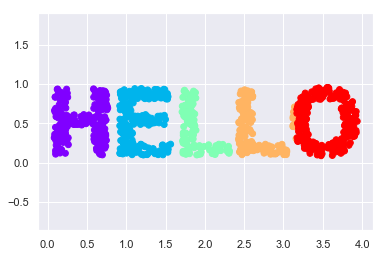

In [18]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

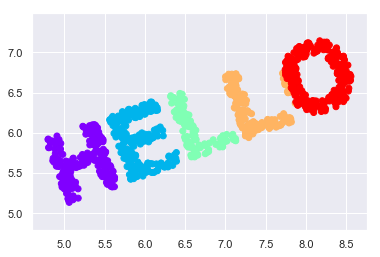

In [19]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

###### We see that what matters in clustering the above dataset is not the x-y axis representation of the dataset but the distance between the different points!

In [20]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape


(1000, 1000)

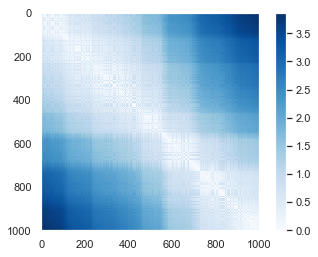

In [21]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

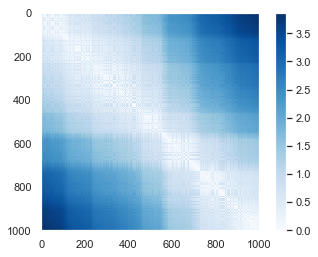

In [22]:
D2 = pairwise_distances(X2)
plt.imshow(D2, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [23]:
np.allclose(D, D2) ## this is another command to check if the distance matries are the same!

True

## Multi-Dimensional Scaling

 Given point $X_1, \ldots, X_n$, compute the distance matrix $D \in \mathbb{R}^{d\times d}$ and find points $Y_1,\ldots, Y_n \in \mathbb{R}^k$ to preserve distance:
        $$ L_D(Y_1, \ldots, Y_N) = \left(\sum_{i \neq j = 1, \ldots, N} \left(D_{i,j} - \| Y_i - Y_j \|_2^2\right) \right)^{1/2}$$
Could be reformulated as an Eigenvector problem (with some effort).

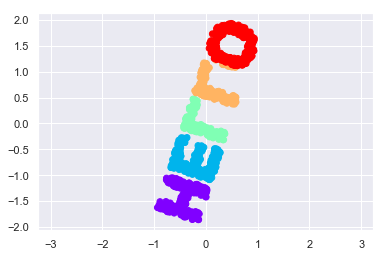

In [24]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D) ## THis is where you are passing the computed dissimilarity from last step to the MDS command.
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

In [25]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

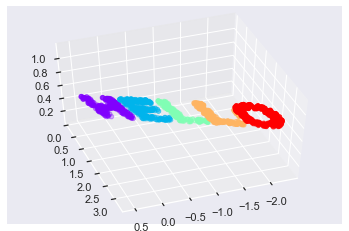

In [26]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

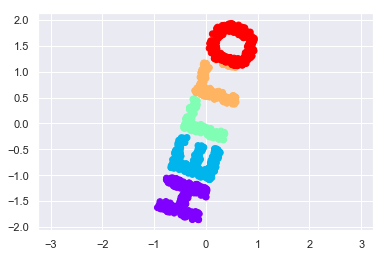

In [12]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

Where MDS Fails ?

In [13]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

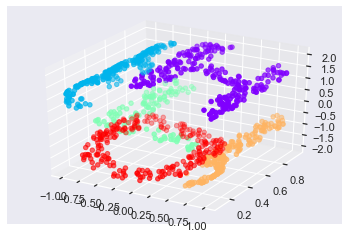

In [14]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

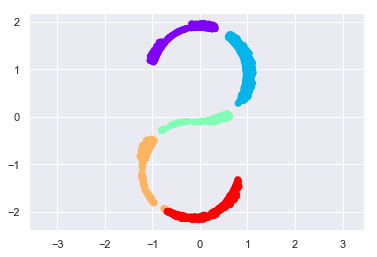

In [15]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS) ###XS is the dataset
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

## Local-Linear Embedding

LLE proceeds as follows:

1) For each data sample $X_i\in \mathbb{R}^d$, find its $k$ nearest neighbors.

2) Find the weight matrix $w \in \mathbb{R}^{n \times n}$ which minimizes the residual sum of squares for reconstructing each $X_i$ from its neighbors:
                $$ RSS(w)  = \sum_{i} \| X_i - \sum_{j \neq i}w_{ij} X_j \|_2^2$$
where $w_{ij} = 0$ unless $X_j$ is one of the $k$-nearest neighbors and for each $i$, $\sum_j w_{ij} = 1 $.

3)Find coordinates $Y_1,\ldots,Y_n \in \mathbb{R}^k$, corresponding to data sample $X_1,\ldots, X_n$, that minimzes:
                $$ \sum_{i} \| Y_i - \sum_{j \neq i}w_{ij} Y_j \|_2^2$$
subjected to the constraints that $\sum_i Y_{ij} = 0 $ for each $j$ and $\|Y_i\|_2 =1$ and $Y_i^\top Y_j = 0$ for $i\neq j$.


More info here: https://www.stat.cmu.edu/~cshalizi/350/lectures/14/lecture-14.pdf and https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf

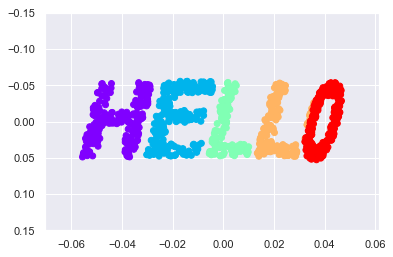

In [42]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS) ###XS is the dataset that is originally the twisted HELLO

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

###### Now some real data - the MNIST digits dataset

## ISOMAP

Proposed in  https://web.mit.edu/cocosci/Papers/sci_reprint.pdf

A very high-level description of Isomap algorithm is given below.

1) Determine the neighbors of each point:
        a) All points in some fixed radius.
        b) K nearest neighbors.
        
2) Construct a neighborhood graph:
        a) Each point is connected to other if it is a K nearest neighbor.
        b) Edge length equal to Euclidean distance.

3) Compute shortest path between two nodes:
        a) Dijkstra's algorithm
        b) Floyd–Warshall algorithm

4) Compute lower-dimensional embedding:
        a) Multidimensional scaling

In [31]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


(70000, 784)

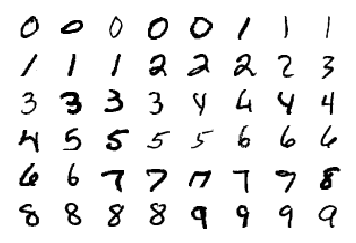

In [17]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

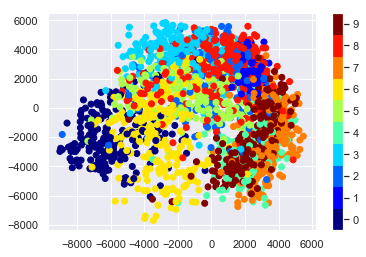

In [18]:
from sklearn.manifold import Isomap

# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

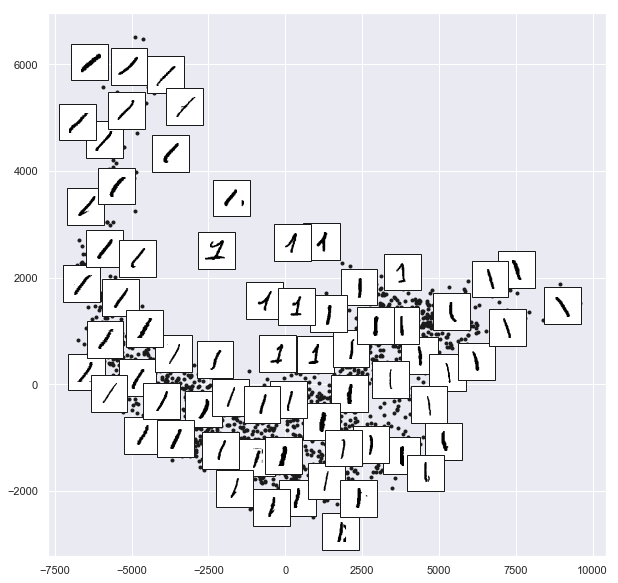

In [19]:
#### This is just a function to do some fancy plotting## NO need to understand in detail####
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            
            
#######

from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

## T-distributed Stochastic Neighborhood Embedding

Proposed first in http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

The idea here is to mimimize the KL divergence between a distribution $P$ in the original $d$-dimensional space and a distribution $Q$ in the reduced $k$-dimensional space.

In [1]:
from sklearn import datasets
digits = datasets.load_digits() 
# Take the first 500 data points: it's hard to see 1500 points ##Each data is 64 dimensional
X = digits.data[:500]
y = digits.target[:500]

In [2]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)


In [3]:
X_2d = tsne.fit_transform(X)


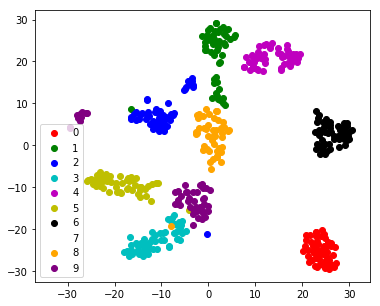

In [9]:
target_ids = range(len(digits.target_names))

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, digits.target_names):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=label)
plt.legend()
plt.show()


## Back to Clustering: Hierarchical Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('Wholesale customers data.csv')
data.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
from sklearn.preprocessing import normalize
data_scaled = normalize(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
data_scaled.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.000112,0.000168,0.708333,0.539874,0.422741,0.011965,0.149505,0.074809
1,0.000125,0.000188,0.442198,0.614704,0.599540,0.110409,0.206342,0.111286
2,0.000125,0.000187,0.396552,0.549792,0.479632,0.150119,0.219467,0.489619
3,0.000065,0.000194,0.856837,0.077254,0.272650,0.413659,0.032749,0.115494
4,0.000079,0.000119,0.895416,0.214203,0.284997,0.155010,0.070358,0.205294


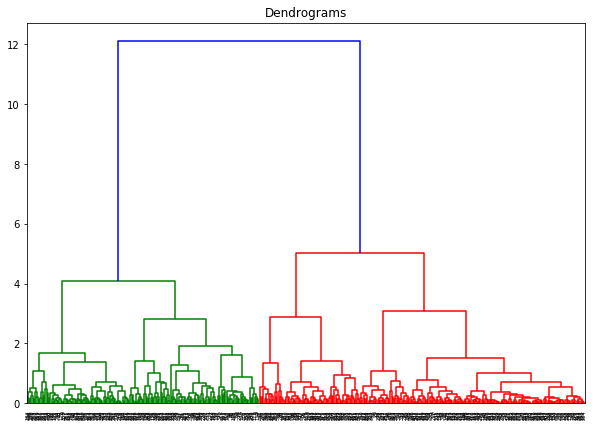

In [5]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))

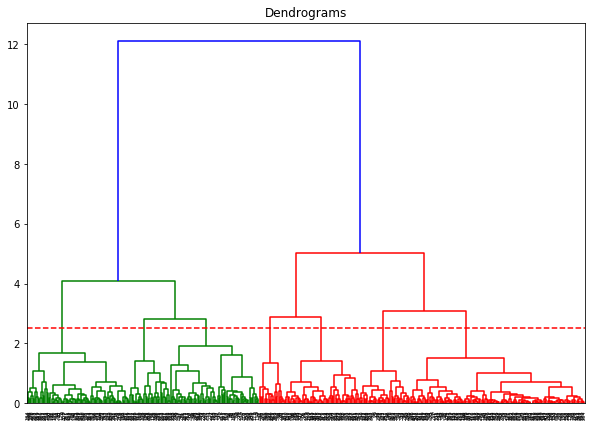

In [12]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
plt.axhline(y=2.5, color='r', linestyle='--')

In [13]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(data_scaled)

array([1, 1, 1, 2, 0, 1, 0, 1, 1, 3, 3, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2,
       0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 1, 3, 0, 1, 1, 0, 0, 0, 1, 3,
       1, 1, 3, 1, 1, 3, 2, 1, 0, 3, 0, 1, 3, 1, 0, 1, 0, 1, 1, 1, 2, 3,
       3, 0, 1, 0, 2, 0, 2, 2, 1, 0, 2, 1, 0, 1, 0, 3, 1, 0, 0, 3, 1, 0,
       2, 0, 0, 2, 1, 2, 1, 3, 3, 2, 2, 2, 1, 3, 1, 0, 0, 0, 3, 1, 1, 3,
       0, 1, 2, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 0, 2, 0, 1, 0, 2, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 1,
       0, 3, 3, 0, 3, 3, 3, 0, 0, 3, 1, 1, 1, 1, 0, 2, 3, 1, 3, 3, 3, 3,
       0, 0, 0, 1, 0, 0, 3, 1, 3, 2, 2, 3, 1, 1, 2, 0, 0, 3, 0, 2, 2, 3,
       2, 0, 3, 3, 0, 3, 3, 3, 0, 1, 3, 3, 0, 3, 0, 1, 3, 3, 3, 0, 3, 2,
       0, 1, 2, 2, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0,
       0, 0, 1, 3, 0, 0, 0, 2, 2, 3, 2, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 3,
       3, 1, 3, 0, 1, 0, 2, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 0, 0, 2, 0, 0,
       0, 2, 0, 0, 1, 2, 3, 1, 0, 0, 0, 0, 1, 3, 0,

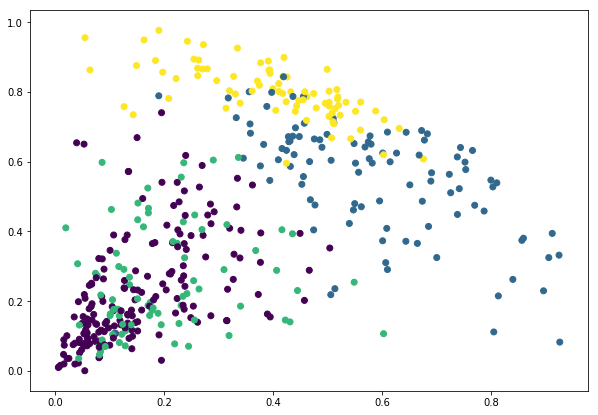

In [14]:
plt.figure(figsize=(10, 7))  
plt.scatter(data_scaled['Milk'], data_scaled['Grocery'], c=cluster.labels_) 

## Back to k-Means: Some issues with k-means

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

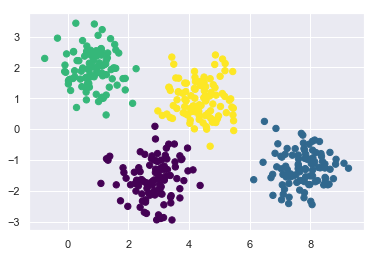

In [26]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');


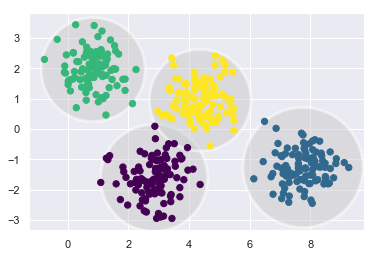

In [30]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None): ### a function to draw the circle around each cluster
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

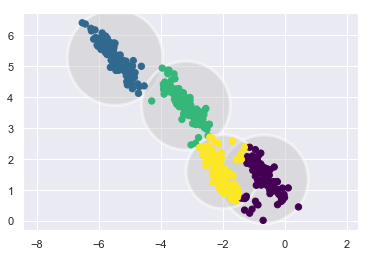

In [31]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

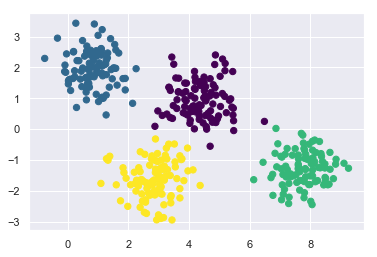

In [35]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [39]:
probs = gmm.predict_proba(X) ### probs
print(probs.shape)


(400, 4)


In [40]:
print(probs[:5].round(3))

[[0.537 0.    0.463 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


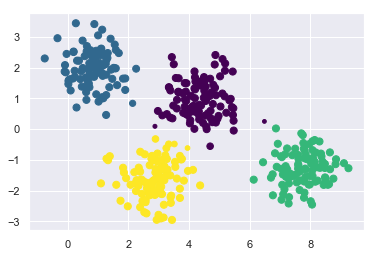

In [41]:
# A different visualization: the size of the visualization corresponds to the confidence 
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [48]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None): ## Some fancy plotting based on the gmm
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)


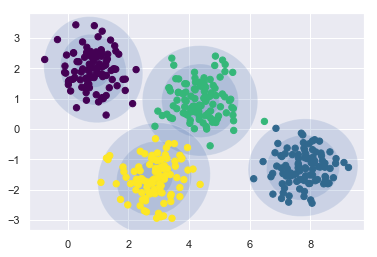

In [49]:
gmm = GaussianMixture(n_components=4).fit(X)
plot_gmm(gmm, X)

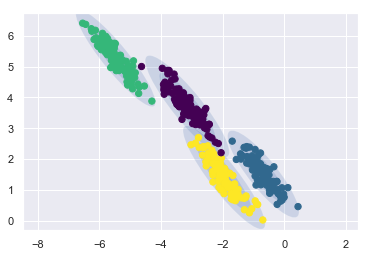

In [50]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

## GMM as Density Estimation

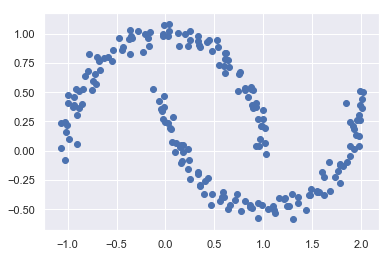

In [78]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

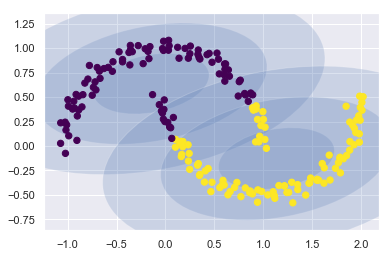

In [53]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

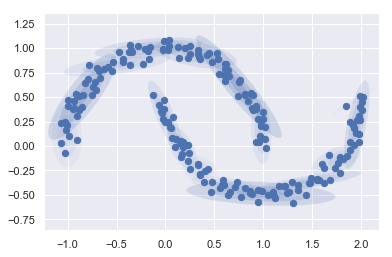

In [55]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

In [99]:
##Sample from this density 

Xnew = gmm16.sample(400)

Xnew ## try plotting this array



(array([[-9.18024344e-01,  4.26485299e-01],
        [-7.91147947e-01,  7.01983261e-01],
        [-1.02085389e+00,  2.28507453e-01],
        [-8.49863702e-01,  4.63160149e-01],
        [-7.58708878e-01,  6.79070142e-01],
        [-7.75668085e-01,  5.33726539e-01],
        [-8.77616781e-01,  2.98794495e-01],
        [-8.75869101e-01,  4.66358774e-01],
        [-8.26967221e-01,  5.16957255e-01],
        [-8.57433289e-01,  4.07138872e-01],
        [-7.56305202e-01,  4.82886098e-01],
        [-7.60436031e-01,  5.79550598e-01],
        [-8.51546440e-01,  4.33701144e-01],
        [-8.01334883e-01,  5.35457949e-01],
        [-9.52839885e-01,  3.27842151e-01],
        [-8.95256594e-01,  4.41091751e-01],
        [-1.03783985e+00,  3.11804895e-01],
        [-7.82069282e-01,  5.33717166e-01],
        [-7.80641768e-01,  5.30213970e-01],
        [-7.71097271e-01,  5.95618849e-01],
        [-9.92530215e-01,  4.70955895e-01],
        [-7.96534988e-01,  4.23687817e-01],
        [-8.31671787e-01,  4.526

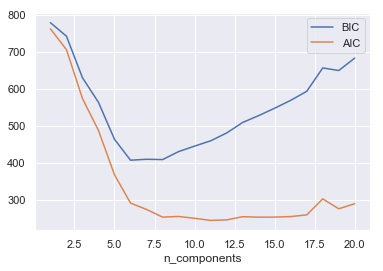

In [100]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [101]:
##Real Data

from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

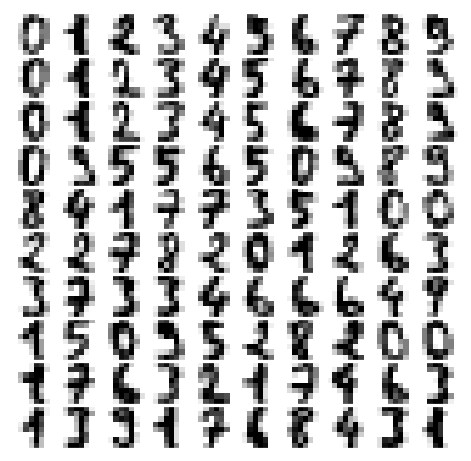

In [102]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)


In [103]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

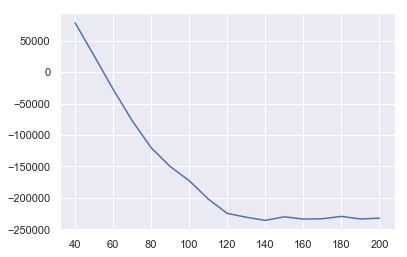

In [110]:
n_components = np.arange(40, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [112]:
gmm = GaussianMixture(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [115]:
data_new = gmm.sample(100)


Excercise: Plot the figures to see how to turn out!